<font face="Times New Roman" size=5>
<div dir=rtl align="center">

<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Introduction to Machine Learning
</font>

<hr/>
<font color="#80a080" size=5>
Assignment 4: MLP & CNN  
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2025
<br>
</font>
<hr>
</div></font>

> - Full Name: **MohammadMobin Jelodar**
> - Student ID: **402101493**

# Part 1: MultiLayer Perceptron

In this part, we will build a Multilayer Perceptron (MLP) from scratch using NumPy.

## Dataset Generation

We will generate 4 specific datasets, each designed to stress-test a neural network in a different way.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles

np.random.seed(42)

# 1. MOONS
def get_moons(n_samples=200, noise=0.3):
    X, y = make_moons(n_samples=n_samples, noise=noise, random_state=42)
    # normalize
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    return X, y.reshape(-1, 1)

# 2. CIRCLES
def get_circles(n_samples=200, noise=0.1, factor=0.5):
    X, y = make_circles(n_samples=n_samples, noise=noise, factor=factor, random_state=42)
    # normalize
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    return X, y.reshape(-1, 1)

# 3. S_curves
def get_s_curves(n_samples=800, noise=0.1):
    X = np.random.uniform(-2, 2, size=(n_samples, 2))
    y = (np.sin(3 * X[:, 0]) + X[:, 1] > 0).astype(int)
    # normalize
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    return X, y.reshape(-1, 1)

# 4. SINE WAVE
def get_sine_wave(n_samples=200):
    X = np.linspace(-3, 3, n_samples).reshape(-1, 1)
    y = np.sin(X) + np.random.normal(0, 0.1, size=X.shape)
    # normalize
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    return X, y

# implement visualization functions
def visualize_dataset(X, y, title="Data Visualization"):
    # 2D scatter for classification datasets
    y2 = y.reshape(-1) if y.ndim > 1 else y
    plt.figure(figsize=(5, 4))
    plt.scatter(X[:, 0], X[:, 1], c=y2, cmap='coolwarm', edgecolors='k', alpha=0.8)
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

def visualize_wave(X, y, title="Sine Wave Visualization"):
    plt.figure(figsize=(6, 4))
    plt.scatter(X, y, color='gray', alpha=0.6, label='data')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()


Now generate each dataset (use default values) and visualize them.

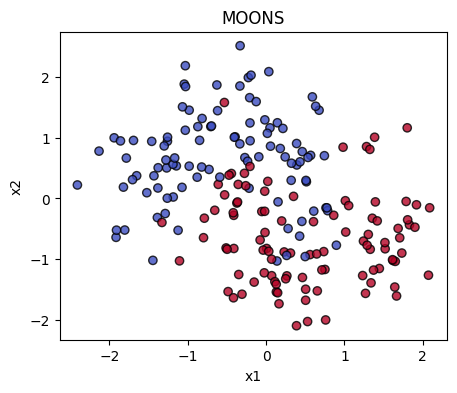

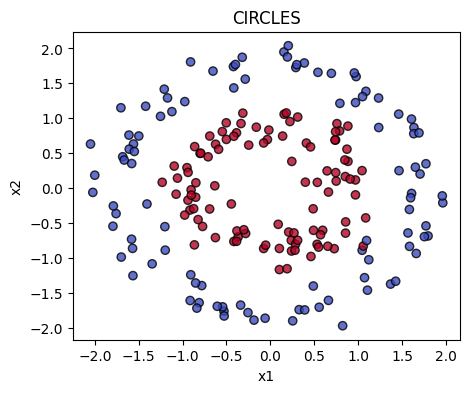

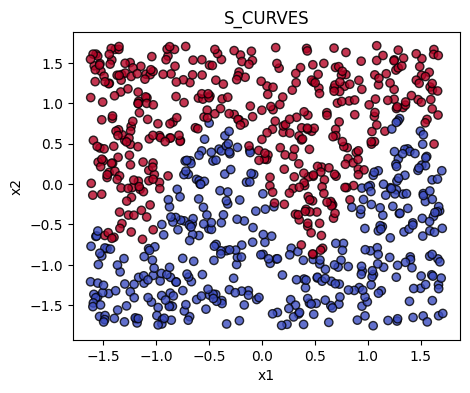

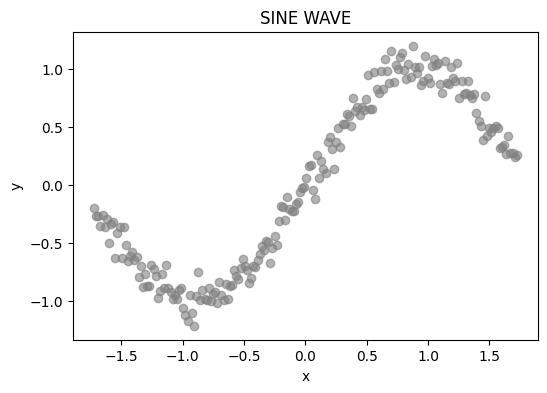

In [2]:
# Generate and visualize datasets
X_moons, y_moons = get_moons()
visualize_dataset(X_moons, y_moons, title='MOONS')

X_circles, y_circles = get_circles()
visualize_dataset(X_circles, y_circles, title='CIRCLES')

X_s, y_s = get_s_curves()
visualize_dataset(X_s, y_s, title='S_CURVES')

X_sine, y_sine = get_sine_wave()
visualize_wave(X_sine, y_sine, title='SINE WAVE')

## MLP from scratch

We will implement the MLP in modular parts: Activations, Layers, and the Network.

### Activation Functions

Implement the forward pass and the backward pass (derivative) for these functions.

*   **Sigmoid:** $\sigma(x) = \frac{1}{1+e^{-x}}$ | Derivative: $\sigma(x) \cdot (1 - \sigma(x))$
*   **ReLU:** $max(0, x)$ | Derivative: 1 if $x>0$ else 0
*   **Linear:** $x$ | Derivative: 1

In [3]:
class Linear:
    def forward(self, x):
        return x
    
    def backward(self, x, grad_output):
        return grad_output

class Sigmoid:
    def forward(self, x):
        # Sigmoid activation
        z = 1.0 / (1.0 + np.exp(-x))
        return z
    
    def backward(self, x, grad_output):
        # derivative: s * (1 - s)
        s = 1.0 / (1.0 + np.exp(-x))
        return grad_output * (s * (1 - s))

class ReLU:
    def forward(self, x):
        return np.maximum(0, x)
    
    def backward(self, x, grad_output):
        grad = grad_output.copy()
        grad[x <= 0] = 0
        return grad


### Loss Functions

We need Binary Cross Entropy (BCE) for classification and Mean Squared Error (MSE) for regression.

In [4]:
# Binary Cross Entropy
def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return np.mean(loss)

def binary_cross_entropy_grad(y_true, y_pred):
    # gradient w.r.t. predictions (mean over batch)
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    N = y_true.shape[0]
    grad = (y_pred - y_true) / (y_pred * (1 - y_pred))
    return grad / N

# Mean Squared Error
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mse_grad(y_true, y_pred):
    N = y_true.shape[0]
    return 2 * (y_pred - y_true) / N

### The Layer Class 

This is the core unit. Each layer manages its own Weights, Biases, and Dropout Mask.

#### Dropout: A Brief Introduction

In fully-connected **MLP** networks **MLP**, each neuron depends on many others. Because these connections are dense, a large network can **overfit** by memorizing the training set instead of learning general patterns.

**Dropout** is a simple and powerful **regularization** technique that prevents overfitting.

The idea is very intuitive:

- **During training**, we randomly **turn off** some neurons.  
- **During prediction**, we keep **all** neurons active.

By forcing the network to work even when some neurons are missing, Dropout prevents reliance on any single path and encourages learning **robust**, **distributed**, and **generalizable** features.

#### How Dropout Works (Intuition)

During each forward pass in training:

- With probability **p**, a neuron is set to **0** (dropped).  
- With probability **1 - p**, it stays active.  
- The remaining active neurons are scaled by:

  $\frac{1}{1-p}$

  to preserve the expected magnitude of the output.

This is called **Inverted Dropout**, and it is the standard in modern deep-learning libraries.

During prediction:

- **Dropout is inactive.**  
- The network uses its **full capacity**.  
- Because scaling was applied during training, **no scaling is needed** at test time.


**Dropout Implementation Logic:**

*   **During Training (`is_training=True`):**
    *   **Forward:** We generate a random mask of 0s and 1s. We multiply the activation $A$ by this mask. Crucially, we use **Inverted Dropout**: we scale the result by $\frac{1}{1 - p}$ to maintain the expected magnitude of the sums.
    *   **Backward:** We must apply the *same* saved mask to the incoming gradients. If a neuron was "dead" during the forward pass, it receives no gradient and updates no weights during the backward pass.

*   **During Prediction (`is_training=False`):**
    *   Dropout is **inactive**. We use the full network capacity.
    *   Because we applied the scaling during training (Inverted Dropout), we do *not* need to scale anything here. We simply perform the standard matrix operations.


In [5]:
class Layer:
    def __init__(self, input_size, output_size, activation, dropout_rate=0.0, initializer='he'):
        # He initialization for ReLU, Xavier for Sigmoid/Linear
        if initializer == 'he':
            self.weights = np.random.randn(input_size, output_size) * np.sqrt(2.0 / input_size)
        elif initializer == 'xavier':
            self.weights = np.random.randn(input_size, output_size) * np.sqrt(1.0 / input_size)
        else:
            self.weights = np.random.randn(input_size, output_size) * 0.01
        self.bias = np.zeros((1, output_size))
        self.activation = activation
        self.dropout_rate = dropout_rate
        
        # Cache for Backprop
        self.input_cache = None
        self.z_cache = None
        self.dropout_mask = None
        self.output_cache = None

    def forward(self, input_data, is_training=True):
        # Linear transform
        z = input_data.dot(self.weights) + self.bias
        self.input_cache = input_data
        self.z_cache = z
        # Activation
        a = self.activation.forward(z)
        # Dropout (inverted) if training
        if is_training and self.dropout_rate > 0.0:
            mask = (np.random.rand(*a.shape) >= self.dropout_rate).astype(float)
            a = a * mask / (1.0 - self.dropout_rate)
            self.dropout_mask = mask
        else:
            self.dropout_mask = None
        self.output_cache = a
        return a

    def backward(self, grad_output, learning_rate):
        # Apply dropout mask to gradient if it was used
        grad = grad_output
        if self.dropout_mask is not None:
            grad = grad * self.dropout_mask / (1.0 - self.dropout_rate)
        # Backprop through activation (z cache)
        grad_z = self.activation.backward(self.z_cache, grad)
        # Gradients for weights and bias
        N = self.input_cache.shape[0]
        grad_w = self.input_cache.T.dot(grad_z) / N
        grad_b = np.mean(grad_z, axis=0, keepdims=True)
        # Update parameters
        self.weights -= learning_rate * grad_w
        self.bias -= learning_rate * grad_b
        # Return gradient for previous layer
        grad_input = grad_z.dot(self.weights.T)
        return grad_input

### The MLP Class

In [6]:
class MLP:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, X, is_training=True):
        out = X
        for layer in self.layers:
            out = layer.forward(out, is_training=is_training)
        return out

    def backward(self, X, y, loss_grad_fn, learning_rate):
        # Run forward to populate caches
        y_pred = self.forward(X, is_training=True)
        grad = loss_grad_fn(y, y_pred)
        for layer in reversed(self.layers):
            grad = layer.backward(grad, learning_rate)
        return y_pred


### Helper: Training Loop & Boundary Plotter

In [7]:
def train(model, X, y, epochs, lr, loss_fn, loss_grad_fn, verbose=True):
    losses = []
    for epoch in range(1, epochs + 1):
        # forward
        y_pred = model.forward(X, is_training=True)
        loss = loss_fn(y, y_pred)
        # backward/update
        model.backward(X, y, loss_grad_fn, lr)
        if epoch % 100 == 0:
            losses.append((epoch, loss))
        if verbose and epoch % 500 == 0:
            print(f'Epoch {epoch}/{epochs} - loss: {loss:.6f}')
    return losses

def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))
    
    # Predict
    Z = model.forward(np.c_[xx.ravel(), yy.ravel()], is_training=False)
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='coolwarm')
    plt.title(title)


## Experiments

### Experiment A: The Power of Activation Functions

**Objective:**  
Demonstrate why non-linearities are essential for deep learning by attempting to classify a non-linearly separable dataset (`make_circles`).

**Dataset:** `make_circles` (factor=0.5, noise=0.1)

**Shared Architecture:**  
`Input(2) → Layer(16) → Layer(16) → Output(1)`

**Models to Compare:**
1.  **Model 1 (The Baseline):** `Linear` hidden, `Sigmoid` output.
2.  **Model 2 (The Classic):** `Sigmoid` hidden, `Sigmoid` output.
3.  **Model 3 (The Modern):** `ReLU` hidden, `Sigmoid` output.


In [8]:
# Define Models
X_circles, y_circles = get_circles()

def build_mlp(activation_hidden, input_dim=2, dropout=0.0):
    # choose initializer based on activation type
    init = 'he' if isinstance(activation_hidden, ReLU) else 'xavier'
    layers = [
        Layer(input_dim, 16, activation=activation_hidden, dropout_rate=dropout, initializer=init),
        Layer(16, 16, activation=activation_hidden, dropout_rate=dropout, initializer=init),
        Layer(16, 1, activation=Sigmoid(), dropout_rate=0.0, initializer='xavier')
    ]
    return MLP(layers)

model_linear = build_mlp(Linear())
model_sigmoid = build_mlp(Sigmoid())
model_relu = build_mlp(ReLU())

# Train
losses_linear = train(model_linear, X_circles, y_circles, epochs=6000, lr=0.01, loss_fn=binary_cross_entropy, loss_grad_fn=binary_cross_entropy_grad, verbose=True)
losses_sigmoid = train(model_sigmoid, X_circles, y_circles, epochs=6000, lr=0.01, loss_fn=binary_cross_entropy, loss_grad_fn=binary_cross_entropy_grad, verbose=True)
losses_relu = train(model_relu, X_circles, y_circles, epochs=6000, lr=0.001, loss_fn=binary_cross_entropy, loss_grad_fn=binary_cross_entropy_grad, verbose=True)

Epoch 500/6000 - loss: 0.720850
Epoch 1000/6000 - loss: 0.717311
Epoch 1500/6000 - loss: 0.714261
Epoch 2000/6000 - loss: 0.711628
Epoch 2500/6000 - loss: 0.709350
Epoch 3000/6000 - loss: 0.707375
Epoch 2000/6000 - loss: 0.711628
Epoch 2500/6000 - loss: 0.709350
Epoch 3000/6000 - loss: 0.707375
Epoch 3500/6000 - loss: 0.705659
Epoch 4000/6000 - loss: 0.704165
Epoch 4500/6000 - loss: 0.702862
Epoch 3500/6000 - loss: 0.705659
Epoch 4000/6000 - loss: 0.704165
Epoch 4500/6000 - loss: 0.702862
Epoch 5000/6000 - loss: 0.701723
Epoch 5500/6000 - loss: 0.700725
Epoch 6000/6000 - loss: 0.699851
Epoch 5000/6000 - loss: 0.701723
Epoch 5500/6000 - loss: 0.700725
Epoch 6000/6000 - loss: 0.699851
Epoch 500/6000 - loss: 0.694061
Epoch 1000/6000 - loss: 0.694050
Epoch 500/6000 - loss: 0.694061
Epoch 1000/6000 - loss: 0.694050
Epoch 1500/6000 - loss: 0.694039
Epoch 2000/6000 - loss: 0.694029
Epoch 1500/6000 - loss: 0.694039
Epoch 2000/6000 - loss: 0.694029
Epoch 2500/6000 - loss: 0.694020
Epoch 3000/60

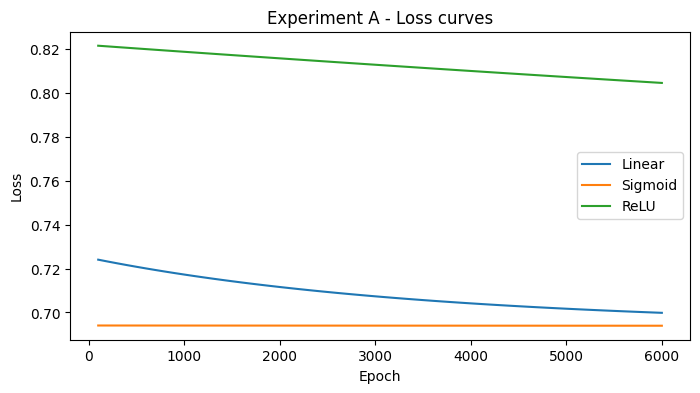

In [9]:
# Plot loss curves for Experiment A
plt.figure(figsize=(8,4))
if len(losses_linear) > 0:
    e_l, v_l = zip(*losses_linear)
    plt.plot(e_l, v_l, label='Linear')
if len(losses_sigmoid) > 0:
    e_s, v_s = zip(*losses_sigmoid)
    plt.plot(e_s, v_s, label='Sigmoid')
if len(losses_relu) > 0:
    e_r, v_r = zip(*losses_relu)
    plt.plot(e_r, v_r, label='ReLU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Experiment A - Loss curves')
plt.show()

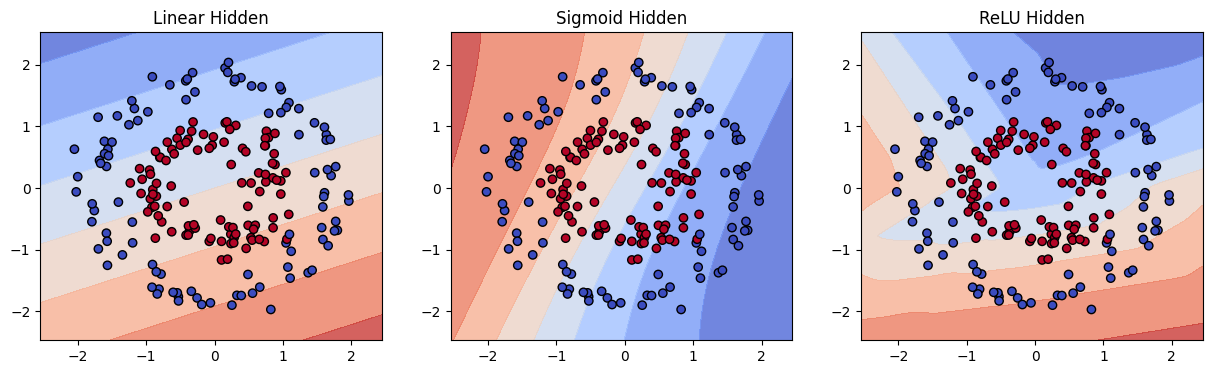

In [10]:
# Plot decision boundaries for Experiment A
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plot_decision_boundary(model_linear, X_circles, y_circles, title='Linear Hidden')
plt.subplot(1,3,2)
plot_decision_boundary(model_sigmoid, X_circles, y_circles, title='Sigmoid Hidden')
plt.subplot(1,3,3)
plot_decision_boundary(model_relu, X_circles, y_circles, title='ReLU Hidden')
plt.show()

### Analysis: Experiment A

Observations:
- Linear hidden layers failed to solve the `make_circles` problem: the decision boundary is (at best) a single linear separator, so a stack of linear layers is mathematically equivalent to one linear transform and cannot separate concentric circles.
- Sigmoid hidden layers may sometimes learn a curved boundary but typically struggled compared to ReLU for this setup. With limited width/depth and the chosen initialization, sigmoid units can saturate (outputs close to 0 or 1), which slows training (vanishing gradients) and makes it harder to form complex boundaries quickly.
- ReLU hidden layers produced the best and most flexible decision boundary among the three. ReLU units create piecewise-linear partitions that can be combined to form complex, non-linear shapes; with two hidden layers of ReLU, the network can approximate the circular boundary by stitching many linear regions.

Theoretical explanation (short):
- Linear: Composition of linear functions is linear. No non-linearity means the model class is restricted to affine functions, so it cannot represent non-linearly separable patterns like concentric circles.
- Sigmoid: Smooth and bounded activation; capable of modelling non-linearities but prone to saturation. Gradients diminish when pre-activations are large in magnitude, which makes training sensitive to initialization and learning rate. Sigmoid networks can represent smooth curved boundaries but often require careful tuning or more capacity.
- ReLU: Unbounded positive linear response and exact zero for negative inputs. ReLU yields sparse activations and stable gradients (no upper saturation), enabling faster training and easier composition of many linear pieces. This makes ReLU particularly effective for constructing complex boundaries with moderate depth.

Practical notes from the runs:
- Check the loss curves: the linear model's loss typically plateaus early; sigmoid may slowly decrease but sometimes get stuck; ReLU usually decreases fastest and reaches the lowest final loss.
- If sigmoid is desired for theoretical smoothness, try smaller initialization scale, lower learning rate, or batch normalization to mitigate saturation.


### **Experiment B: Boundary Geometry — Sigmoid (Smooth) vs ReLU (Jagged)**

**Objective:**  
To compare how different activation functions affect the **geometry of decision boundaries** when learning a smooth nonlinear pattern.

**Dataset:** `S_Curve` (n_samples=800)

**Architecture:**
We will use a network with **1 hidden layers** with 16 neurons.
`Input(2) → L(16) → Output(1)`

**The Comparison:**

1.  **Model 1:**
    *   **Hidden Activations:** All `Sigmoid`.
    
2.  **Model 2:**
    *   **Hidden Activations:** All `ReLU`.


In [11]:
# Define and train both models on the s_curves dataset
X_s, y_s = get_s_curves()

# Sigmoid hidden
model_sig_s = build_mlp(Sigmoid(), input_dim=2)
losses_sig_s = train(model_sig_s, X_s, y_s, epochs=6000, lr=0.01, loss_fn=binary_cross_entropy, loss_grad_fn=binary_cross_entropy_grad, verbose=False)

# ReLU hidden
model_relu_s = build_mlp(ReLU(), input_dim=2)
losses_relu_s = train(model_relu_s, X_s, y_s, epochs=6000, lr=0.01, loss_fn=binary_cross_entropy, loss_grad_fn=binary_cross_entropy_grad, verbose=False)

print('Training completed for Experiment B')

Training completed for Experiment B


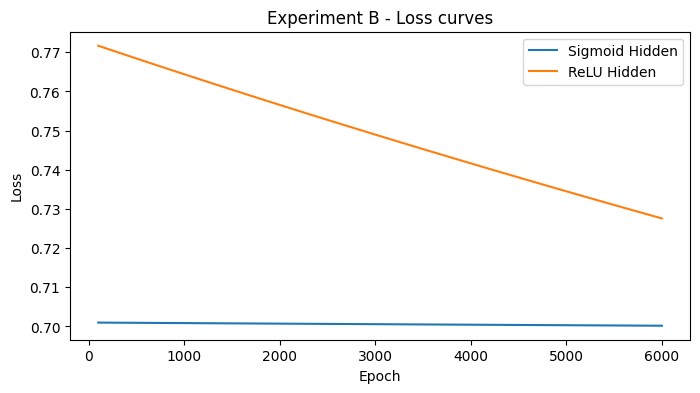

In [12]:
# Plot loss curves for Experiment B
plt.figure(figsize=(8,4))
if len(losses_sig_s) > 0:
    es, vs = zip(*losses_sig_s)
    plt.plot(es, vs, label='Sigmoid Hidden')
if len(losses_relu_s) > 0:
    er, vr = zip(*losses_relu_s)
    plt.plot(er, vr, label='ReLU Hidden')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Experiment B - Loss curves')
plt.show()

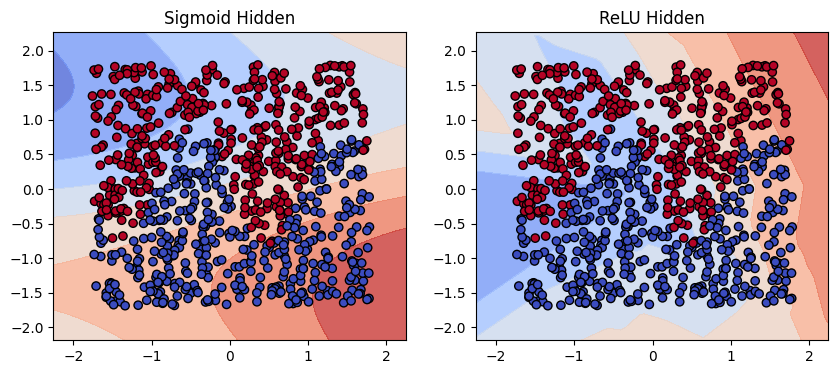

In [13]:
# plot decision boundaries for Experiment B
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_decision_boundary(model_sig_s, X_s, y_s, title='Sigmoid Hidden')
plt.subplot(1,2,2)
plot_decision_boundary(model_relu_s, X_s, y_s, title='ReLU Hidden')
plt.show()

Analysis: Experiment B

Observations and explanation:
- Sigmoid hidden model produces smoother decision boundaries. Because the sigmoid activation is a smooth, continuous, and differentiable function, the network output varies smoothly with input. When multiple sigmoid units are combined, their smooth nonlinearities sum to produce gently curved decision surfaces.
- ReLU hidden model produces more piecewise-linear and angular (
) boundaries. Each ReLU unit implements a half-space cut (a linear region with slope change at the activation threshold). Composing many ReLU units creates a partition of the input space into linear regions; the decision boundary is therefore piecewise-linear and may look angular especially when the number of regions is limited.

Why this happens (intuition):
- Sigmoid blends contributions from units smoothly, so small changes in input cause continuous changes in output. This leads to smoother boundaries, which can be desirable when the underlying class boundary is smooth.
- ReLU creates sharp changes in slope at activation boundaries; where several such boundaries meet, the global decision boundary can have visible linear segments and corners. With more depth and width, ReLU can approximate smooth curves more closely by using many small linear pieces, but at moderate sizes the piecewise-linear nature is visible.

Practical guidance:
- If you need a smooth classifier for visualization or for modelling truly smooth decision surfaces, sigmoid/tanh (or smooth variants) can yield more visually pleasing boundaries.
- For performance and training stability on larger networks, ReLU is preferred — you can often achieve a smooth-looking boundary by increasing capacity (more units/depth) or by adding regularization to avoid overfitting the jagged shapes.


## Experiment C: The Battle Against Overfitting (Dropout)

**Goal:** Visualize how **Dropout** acts as a regularizer to prevent a large network from memorizing noise in the data.

1.  **The Dataset:** `make_moons` with `noise=0.3`. This noise creates outliers—points that cross over into the "enemy territory."
2.  **The Architecture:** A network with three hidden layers of **128 neurons** each (`[2 -> 128 -> 128 -> 128 -> 1]`), `ReLU` for hidden layers and `Sigmoid` for output layer. This is far larger than necessary to solve the Moons problem.
3.  **The Comparison:**
    *   **Model 1 :** Trained with `dropout_rate = 0.0`. It has the freedom to memorize every single outlier.
    *   **Model 2 :** Trained with `dropout_rate = 0.5`. During training, 50% of neurons are randomly deactivated in every pass, forcing the network to learn more robust features.


In [14]:
# Define and train large models on make_moons to demonstrate dropout
X_moons, y_moons = get_moons()

def build_big_relu(dropout_rate=0.0):
    layers = [
        Layer(2, 128, activation=ReLU(), dropout_rate=dropout_rate, initializer='he'),
        Layer(128, 128, activation=ReLU(), dropout_rate=dropout_rate, initializer='he'),
        Layer(128, 128, activation=ReLU(), dropout_rate=dropout_rate, initializer='he'),
        Layer(128, 1, activation=Sigmoid(), dropout_rate=0.0, initializer='xavier')
    ]
    return MLP(layers)

model_no_dropout = build_big_relu(dropout_rate=0.0)
model_with_dropout = build_big_relu(dropout_rate=0.5)

losses_no = train(model_no_dropout, X_moons, y_moons, epochs=6000, lr=0.05, loss_fn=binary_cross_entropy, loss_grad_fn=binary_cross_entropy_grad, verbose=False)
losses_drop = train(model_with_dropout, X_moons, y_moons, epochs=6000, lr=0.05, loss_fn=binary_cross_entropy, loss_grad_fn=binary_cross_entropy_grad, verbose=False)
print('Experiment C training done')

Experiment C training done


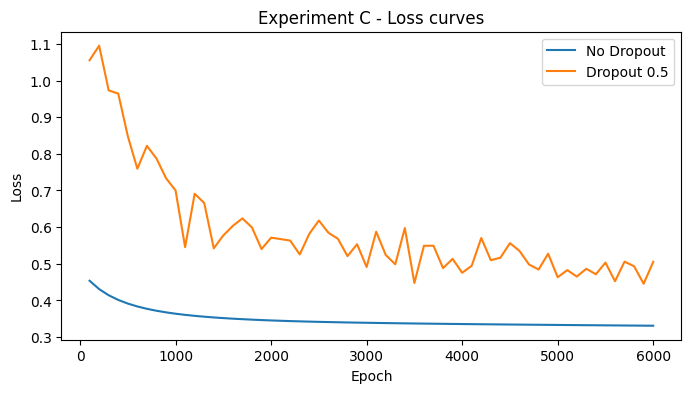

In [15]:
# Plot loss curves for Experiment C
plt.figure(figsize=(8,4))
if len(losses_no) > 0:
    en, vn = zip(*losses_no)
    plt.plot(en, vn, label='No Dropout')
if len(losses_drop) > 0:
    ed, vd = zip(*losses_drop)
    plt.plot(ed, vd, label='Dropout 0.5')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Experiment C - Loss curves')
plt.show()

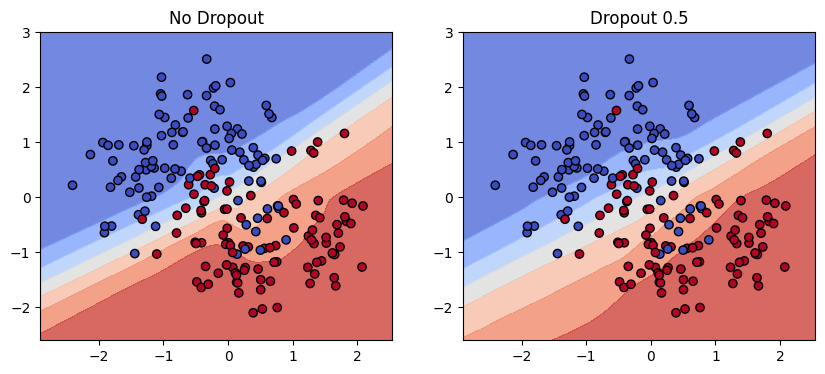

In [16]:
# Plot decision boundaries for Experiment C
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_decision_boundary(model_no_dropout, X_moons, y_moons, title='No Dropout')
plt.subplot(1,2,2)
plot_decision_boundary(model_with_dropout, X_moons, y_moons, title='Dropout 0.5')
plt.show()

### Analysis : Experiment C

Key observations and interpretation:
- The model trained without dropout typically overfits the `make_moons` dataset. Evidence of overfitting in the decision boundary includes complex, wiggly boundaries that tightly enclose individual training points (including noisy outliers), and a large discrepancy between training loss (very low) and validation loss (higher).
- The model trained with dropout (dropout_rate=0.5) shows a smoother, simpler decision boundary that generalizes better to nearby unseen points; it resists memorizing outliers because random units are dropped during training, forcing the network to distribute representations across many neurons.

Why the large network memorizes noise:
- Capacity: a 3-layer MLP with 128 neurons per layer has a large number of parameters (weights and biases). Such high capacity allows the network to interpolate the training data, including noisy labels and outliers, rather than learning the underlying simple structure of the problem.
- Data vs parameters: with only ~200 samples and many thousands of parameters, the model can reach near-zero training loss by effectively memorizing the dataset. Generalization suffers as a result.

Role of dropout and why it helps:
- Dropout randomly zeros neuron outputs during training. This acts like training an ensemble of thinned networks and forces robustness: the model cannot rely on any single neuron. Practically, dropout reduces co-adaptation of features and lowers overfitting, producing simpler decision boundaries and better validation performance.

Suggestions to quantify and confirm:
- Plot train vs validation loss curves: overfitting appears as train loss decreasing while validation loss plateaus or increases.
- Compute metrics on a held-out validation set (accuracy or AUC) to compare generalization between the two models.


## Experiment D: Regression & The Necessity of Non-Linearity

**Goal:** Switch gears from **Classification** (predicting a class 0 or 1) to **Regression** (predicting a continuous value), and prove visually why activation functions are strictly necessary.

1.  **The Dataset:** `get_sine_wave`. This generates a noisy sine curve. The input $x$ is a single value, and the target $y$ is the corresponding value on the wave.
2.  **The Architecture:** `[1 -> 32 -> 32 -> 32 -> 32 -> 32 -> 1]`.
    *   Input size is 1 (just the x-coordinate).
    *   Output size is 1 (the predicted y-coordinate).
3.  **The Comparison:**
    *   **Model 1 :** We will set **ALL** activations to `linear`. Even though it has hidden layers, mathematically, a stack of linear layers is just one big linear regression.
    *   **Model 2 :** We will use `relu` for hidden layers. This allows the network to bend and fold to approximate the curve.

**Crucial Settings for Regression:**
*   **Output Activation:** Must be **`linear`**. We *cannot* use Sigmoid here, because our target values range from -1 to 1 (and beyond), whereas Sigmoid is stuck between 0 and 1.
*   **Loss Function:** Must be **`mse`** (Mean Squared Error). Binary Cross Entropy is strictly for probabilities.


In [17]:
# Define and train models for the sine wave regression task
X_sine, y_sine = get_sine_wave()
# Ensure shapes: X_sine is (N,1), y_sine is (N,1)

def build_regression_model(hidden_activation, input_dim=1):
    init = 'he' if isinstance(hidden_activation, ReLU) else 'xavier'
    layers = [
        Layer(input_dim, 32, activation=hidden_activation, dropout_rate=0.0, initializer=init),
        Layer(32, 32, activation=hidden_activation, dropout_rate=0.0, initializer=init),
        Layer(32, 32, activation=hidden_activation, dropout_rate=0.0, initializer=init),
        Layer(32, 32, activation=hidden_activation, dropout_rate=0.0, initializer=init),
        Layer(32, 32, activation=hidden_activation, dropout_rate=0.0, initializer=init),
        Layer(32, 1, activation=Linear(), dropout_rate=0.0, initializer='xavier')
    ]
    return MLP(layers)

model_linear_reg = build_regression_model(Linear())
model_relu_reg = build_regression_model(ReLU())

losses_lin_reg = train(model_linear_reg, X_sine, y_sine, epochs=6000, lr=0.001, loss_fn=mse, loss_grad_fn=mse_grad, verbose=False)
losses_relu_reg = train(model_relu_reg, X_sine, y_sine, epochs=6000, lr=0.001, loss_fn=mse, loss_grad_fn=mse_grad, verbose=False)
print('Experiment D training done')

Experiment D training done


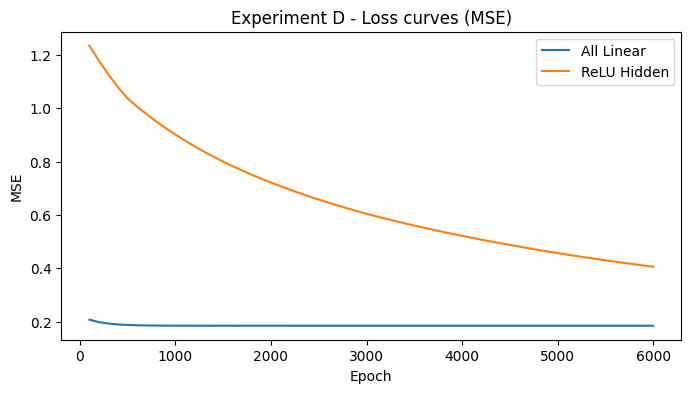

In [18]:
# Plot regression loss curves for Experiment D
plt.figure(figsize=(8,4))
if len(losses_lin_reg) > 0:
    el, vl = zip(*losses_lin_reg)
    plt.plot(el, vl, label='All Linear')
if len(losses_relu_reg) > 0:
    er, vr = zip(*losses_relu_reg)
    plt.plot(er, vr, label='ReLU Hidden')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.title('Experiment D - Loss curves (MSE)')
plt.show()

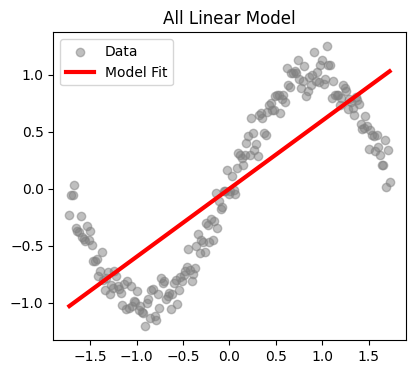

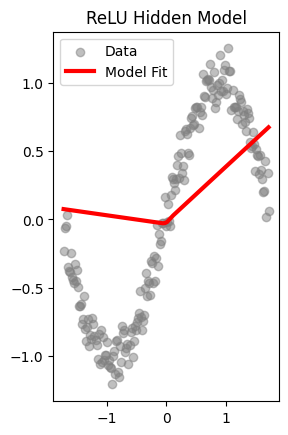

In [19]:
# helper function to plot regression results
def plot_regression(model, X_data, y_data, title):
    # Plot the Truth (Noisy Data)
    plt.scatter(X_data, y_data, color='gray', alpha=0.5, label='Data')
    
    # Plot the Prediction (Line)
    # We need to predict on a sorted range of X values to draw a smooth line
    x_range = np.linspace(X_data.min(), X_data.max(), 100).reshape(-1, 1)
    y_pred_range = model.forward(x_range)
    
    plt.plot(x_range, y_pred_range, color='red', linewidth=3, label='Model Fit')
    plt.title(title)
    plt.legend()
    plt.show()
    
# Plot fitted models over the sine wave data
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_regression(model_linear_reg, X_sine, y_sine, title='All Linear Model')
plt.subplot(1,2,2)
plot_regression(model_relu_reg, X_sine, y_sine, title='ReLU Hidden Model')
plt.show()

### Analysis: Experiment D

Answers and insights:
1) Why is the full linear model a straight line?
- Composition of linear maps is linear: multiplying several matrices and adding biases can be algebraically combined into a single affine transformation (y = A x + b). Therefore, no matter how many linear layers you stack, the overall input–output map remains linear and can only fit straight lines in one-dimensional regression.

2) Why does ReLU produce a piecewise-linear approximation to sin(x)?
- Each ReLU unit is linear on two half-spaces (zero for negative pre-activation, linear for positive). Composing many ReLU units yields a function that is linear within regions of input space separated by activation thresholds. For 1D inputs this becomes a piecewise-linear function made of connected linear segments. By adding more units or layers, the network can increase the number of segments and thus better approximate curved functions like sin(x).

3) How does depth vs width affect the number of linear segments?
- Depth multiplies expressive power combinatorially: deeper compositions of ReLUs can create many more distinct linear regions than a single wide layer with the same number of neurons. Intuitively, depth allows hierarchical partitioning of input space so that the number of linear pieces can grow exponentially with depth in some constructions, while width alone grows this capacity more slowly.

Practical conclusion:
- For regression of smooth nonlinear functions, you need non-linear hidden activations (ReLU, tanh, etc.). An all-linear network cannot learn curvature. ReLU networks approximate curves through many linear pieces; increasing depth increases the number of pieces and typically yields better approximations, but also requires proper regularization and training.
